This file does an EDA based on the MAL dataset, then cleans it further and adds extra parameters as needed.  It then writes a train/eval set and a test set with an 80/20 split.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from collections import Counter, defaultdict
sns.set()

import patsy
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error, mean_absolute_error, max_error

import eda

Data will be the full MAL list (removing those without scores), 20% split off to be test data

In [2]:
mal_raw_df = pd.read_pickle('data\\mal_full\\mal_full_list.pkl')
mal_raw_nonull_df = mal_raw_df[~pd.isnull(mal_raw_df['Score'])]

np.random.seed(42)
df_mask = np.random.rand(len(mal_raw_nonull_df)) < 0.8

mal_df = mal_raw_nonull_df[df_mask]
mal_fortest_df = mal_raw_nonull_df[~df_mask]

In [3]:
mal_raw_df.shape

(16706, 38)

Turns out that ~ 1/3 of the data has no scores attached

In [4]:
mal_raw_nonull_df.shape

(11541, 38)

In [5]:
mal_df.shape

(9262, 38)

In [6]:
mal_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9262 entries, 0 to 16662
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Title                9262 non-null   object        
 1   URL                  9262 non-null   object        
 2   English              4364 non-null   object        
 3   Synonyms             5993 non-null   object        
 4   Japanese             9248 non-null   object        
 5   Type                 9262 non-null   object        
 6   Episodes             9169 non-null   float64       
 7   Status               9262 non-null   object        
 8   Aired                9262 non-null   object        
 9   Premiered            2895 non-null   object        
 10  Broadcast            2895 non-null   object        
 11  Producers            9262 non-null   object        
 12  Licensors            9262 non-null   object        
 13  Studios              9262 non-nu

In [7]:
mal_fortest_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2279 entries, 1 to 16663
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Title                2279 non-null   object        
 1   URL                  2279 non-null   object        
 2   English              1086 non-null   object        
 3   Synonyms             1468 non-null   object        
 4   Japanese             2273 non-null   object        
 5   Type                 2279 non-null   object        
 6   Episodes             2255 non-null   float64       
 7   Status               2279 non-null   object        
 8   Aired                2279 non-null   object        
 9   Premiered            729 non-null    object        
 10  Broadcast            729 non-null    object        
 11  Producers            2279 non-null   object        
 12  Licensors            2279 non-null   object        
 13  Studios              2279 non-nu

In [8]:
mal_df.columns

Index(['Title', 'URL', 'English', 'Synonyms', 'Japanese', 'Type', 'Episodes',
       'Status', 'Aired', 'Premiered', 'Broadcast', 'Producers', 'Licensors',
       'Studios', 'Source', 'Genres', 'Duration', 'Rating', 'Score', 'Ranked',
       'Popularity', 'Members', 'Favorites', 'Started', 'Ended', 'Voters',
       'Adaptation', 'Alternative version', 'Side story', 'Spin-off',
       'Alternative setting', 'Sequel', 'Other', 'Prequel', 'Character',
       'Parent story', 'Summary', 'Full story'],
      dtype='object')

First, let's process Genres

In [9]:
mal_df['Genres']

0        [Action, Military, Adventure, Comedy, Drama, M...
2        [Action, Comedy, Historical, Parody, Samurai, ...
3        [Action, Adventure, Fantasy, Shounen, Super Po...
4                         [Military, Sci-Fi, Space, Drama]
5        [Action, Sci-Fi, Comedy, Historical, Parody, S...
                               ...                        
16656                                             [Hentai]
16657                                       [Hentai, Yaoi]
16660                                             [Hentai]
16661                                             [Hentai]
16662                                     [Action, Hentai]
Name: Genres, Length: 9262, dtype: object

In [10]:
mal_genres_df = eda.createdf_from_listentry(mal_df, 'Genres')
mal_genres_df

Genres_0   Genres_1    Genres_2    Genres_3     Genres_4 Genres_5  \
0        Action   Military   Adventure      Comedy        Drama    Magic   
2        Action     Comedy  Historical      Parody      Samurai   Sci-Fi   
3        Action  Adventure     Fantasy     Shounen  Super Power      NaN   
4      Military     Sci-Fi       Space       Drama          NaN      NaN   
5        Action     Sci-Fi      Comedy  Historical       Parody  Samurai   
...         ...        ...         ...         ...          ...      ...   
16656    Hentai        NaN         NaN         NaN          NaN      NaN   
16657    Hentai       Yaoi         NaN         NaN          NaN      NaN   
16660    Hentai        NaN         NaN         NaN          NaN      NaN   
16661    Hentai        NaN         NaN         NaN          NaN      NaN   
16662    Action     Hentai         NaN         NaN          NaN      NaN   

      Genres_6 Genres_7 Genres_8 Genres_9 Genres_10 Genres_11 Genres_12  
0      Fantasy  Shounen      NaN      NaN       NaN       NaN       NaN  
2      Shounen      NaN      NaN      NaN       NaN       NaN       NaN  
3          NaN      NaN      NaN      NaN       NaN       NaN       NaN  
4          NaN      NaN      NaN      NaN       NaN       NaN       NaN  
5      Shounen      NaN      NaN      NaN       NaN       NaN       NaN  
...        ...      ...      ...      ...       ...       ...       ...  
16656      NaN      NaN      NaN      NaN       NaN       NaN       NaN  
16657      NaN      NaN      NaN      NaN       NaN       NaN       NaN  
16660      NaN      NaN      NaN      NaN       NaN       NaN       NaN  
16661      NaN      NaN      NaN      NaN       NaN       NaN       NaN  
16662      NaN      NaN      NaN      NaN       NaN       NaN       NaN  

[9262 rows x 13 columns]

In [11]:
genre_dummy = eda.createdummy_from_listentries(mal_df, 'Genres')
genre_test_dummy = eda.createdummy_from_listentries(mal_fortest_df, 'Genres')

In [12]:
genre_dummy.columns

Index(['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama',
       'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror',
       'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music',
       'Mystery', 'No genres have been added yet.', 'Parody', 'Police',
       'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen',
       'Shoujo', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports',
       'Super Power', 'Supernatural', 'Thriller', 'Vampire', 'Yaoi'],
      dtype='object')

In [13]:
genre_dummy['No genres have been added yet.'].sum()

13

Drop the dummy column that indicates that no genres were added

In [14]:
genre_dummy = genre_dummy.drop(columns=['No genres have been added yet.'])
genre_test_dummy = genre_test_dummy.drop(columns=['No genres have been added yet.'])

In [15]:
genre_dummy.columns = [entry + " Genre" for entry in genre_dummy.columns]
genre_test_dummy.columns = [entry + " Genre" for entry in genre_test_dummy.columns]

In [16]:
mal_genre_list = genre_dummy.columns.tolist()

Calculate count of genres; note that this is not entirely accurate because not all entries have their genres comprehensively added on MAL

In [17]:
mal_genre_count_dict = {}

mal_genre_count_dict['Genre'] = [genre_name for genre_name in mal_genre_list]
mal_genre_count_dict['Count'] = [genre_dummy[genre_name].sum() for genre_name in mal_genre_list]

mal_genre_count_df = pd.DataFrame(mal_genre_count_dict)

In [18]:
mal_genre_count_df.sort_values('Count', ascending=False)

Genre  Count
0          Action Genre   2495
3          Comedy Genre   1639
11         Hentai Genre    871
1       Adventure Genre    804
20          Music Genre    596
33  Slice of Life Genre    466
6           Drama Genre    392
28         Sci-Fi Genre    305
8         Fantasy Genre    267
4        Dementia Genre    155
21        Mystery Genre    122
15           Kids Genre    121
10          Harem Genre    107
9            Game Genre     97
25        Romance Genre     94
7           Ecchi Genre     91
35         Sports Genre     74
12     Historical Genre     72
16          Magic Genre     69
19       Military Genre     64
18          Mecha Genre     58
13         Horror Genre     47
22         Parody Genre     41
5          Demons Genre     35
37   Supernatural Genre     34
24  Psychological Genre     31
27         School Genre     25
34          Space Genre     19
2            Cars Genre     15
31        Shounen Genre      9
36    Super Power Genre      6
29         Seinen Genre      6
30         Shoujo Genre      6
23         Police Genre      4
26        Samurai Genre      2
17   Martial Arts Genre      2
14          Josei Genre      2
39        Vampire Genre      2
40           Yaoi Genre      2
32     Shounen Ai Genre      1
38       Thriller Genre      1

In [19]:
minor_genre_threshold = 200
mal_genre_count_df['Is Minor?'] = (mal_genre_count_df['Count'] > minor_genre_threshold)

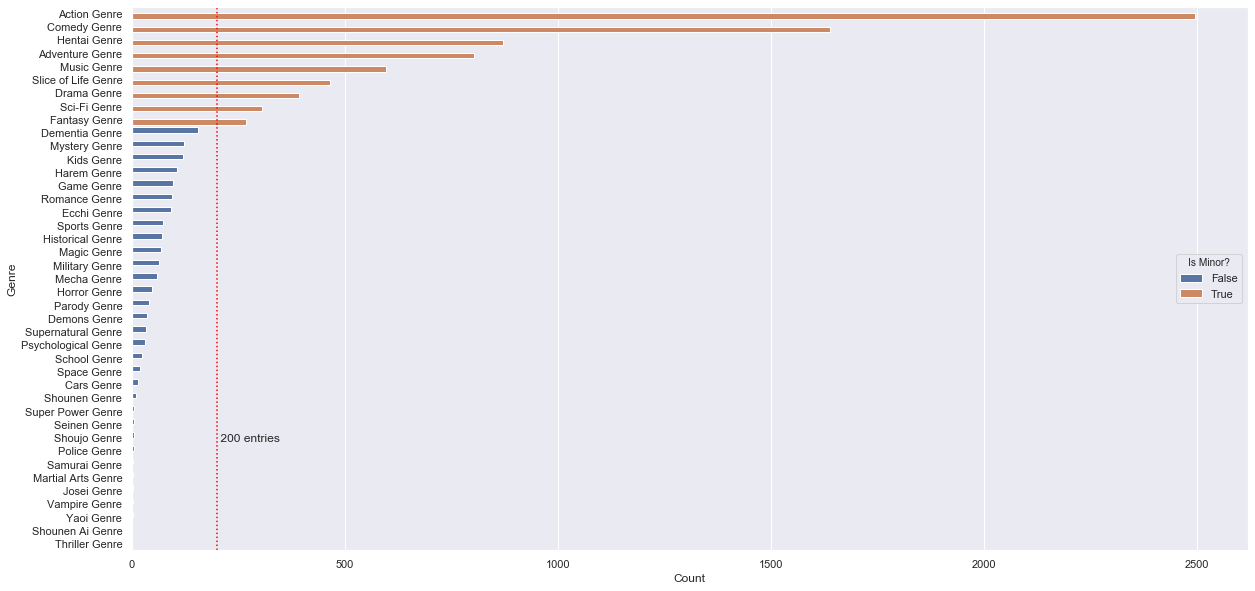

In [20]:
fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(data=mal_genre_count_df.sort_values('Count', ascending=False), y='Genre', x='Count', hue='Is Minor?', ax=ax)
plt.axvline(minor_genre_threshold, color='red', linestyle=':')
plt.text(minor_genre_threshold, 0.2, " " + str(minor_genre_threshold) + " entries", transform=ax.get_xaxis_transform());

Based on the above graph, let's consolidate genres with <= 200 entries into 'Others'

In [21]:
mal_minor_genres_index = mal_genre_count_df[mal_genre_count_df['Count'] <= minor_genre_threshold].Genre.index
mal_minor_genres_list = mal_genre_count_df[mal_genre_count_df['Count'] <= minor_genre_threshold].Genre.tolist()
# test set may not have some genres, correct for that
mal_minor_genres_list_test = list(set(genre_test_dummy.columns.tolist()).intersection(set(mal_minor_genres_list)))

mal_minor_genres_count = mal_genre_count_df[mal_genre_count_df['Count'] <= minor_genre_threshold].Count.sum()
mal_minor_genres_entry = pd.DataFrame({"Genre": ["Other Genre"], "Count": [mal_minor_genres_count]})

In [22]:
mal_genre_cons_count_df = mal_genre_count_df.drop(mal_minor_genres_index)
mal_genre_cons_count_df = pd.concat([mal_minor_genres_entry, mal_genre_cons_count_df], ignore_index=True)
mal_genre_cons_list = mal_genre_count_df[mal_genre_count_df['Count'] > minor_genre_threshold].Genre.tolist()

In [23]:
genre_dummy['Other Genre'] = genre_dummy[mal_minor_genres_list].sum(axis=1)
genre_test_dummy['Other Genre'] = genre_test_dummy[mal_minor_genres_list_test].sum(axis=1)

In [24]:
genre_dummy['Other Genre'].value_counts()

0    7848
1    1414
Name: Other Genre, dtype: int64

In [25]:
genre_dummy = genre_dummy.drop(columns=mal_minor_genres_list)
genre_test_dummy = genre_test_dummy.drop(columns=mal_minor_genres_list_test)

In [26]:
genre_dummy.columns

Index(['Action Genre', 'Adventure Genre', 'Comedy Genre', 'Drama Genre',
       'Fantasy Genre', 'Hentai Genre', 'Music Genre', 'Sci-Fi Genre',
       'Slice of Life Genre', 'Other Genre'],
      dtype='object')

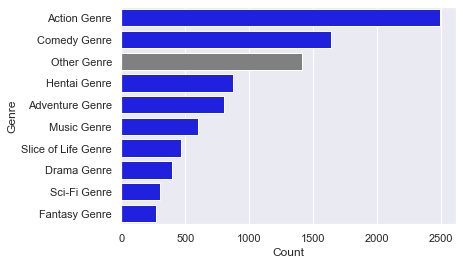

In [130]:
sorted_genrn_cons_df = mal_genre_cons_count_df.sort_values('Count', ascending=False)
clrs = ['grey' if (entry == 'Other Genre') else 'blue' for entry in sorted_genrn_cons_df['Genre']]
sns.barplot(data=sorted_genrn_cons_df, y='Genre', x='Count', palette=clrs);

Let's look at anime types

In [27]:
mal_df['Type'].value_counts()

TV         2895
OVA        2298
Movie      1494
Special    1346
ONA         716
Music       513
Name: Type, dtype: int64

In [28]:
mal_df_type_dummy = pd.get_dummies(mal_df['Type']) #.drop(columns=['TV'])
mal_test_type_dummy = pd.get_dummies(mal_fortest_df['Type'])

In [29]:
mal_df_type_dummy.columns

Index(['Movie', 'Music', 'ONA', 'OVA', 'Special', 'TV'], dtype='object')

In [30]:
mal_df_type_dummy.columns = [entry + " Type" for entry in mal_df_type_dummy.columns]
mal_test_type_dummy.columns = [entry + " Type" for entry in mal_test_type_dummy.columns]

In [31]:
mal_test_type_dummy.columns

Index(['Movie Type', 'Music Type', 'ONA Type', 'OVA Type', 'Special Type',
       'TV Type'],
      dtype='object')

In [32]:
mal_eda_df = pd.concat([mal_df, mal_df_type_dummy, genre_dummy], axis=1)
mal_test_df = pd.concat([mal_fortest_df, mal_test_type_dummy, genre_test_dummy], axis=1)

In [33]:
mal_eda_df['Genre Count'] = mal_eda_df['Genres'].str.len()
mal_test_df['Genre Count'] = mal_test_df['Genres'].str.len()

In [34]:
mal_eda_df.columns

Index(['Title', 'URL', 'English', 'Synonyms', 'Japanese', 'Type', 'Episodes',
       'Status', 'Aired', 'Premiered', 'Broadcast', 'Producers', 'Licensors',
       'Studios', 'Source', 'Genres', 'Duration', 'Rating', 'Score', 'Ranked',
       'Popularity', 'Members', 'Favorites', 'Started', 'Ended', 'Voters',
       'Adaptation', 'Alternative version', 'Side story', 'Spin-off',
       'Alternative setting', 'Sequel', 'Other', 'Prequel', 'Character',
       'Parent story', 'Summary', 'Full story', 'Movie Type', 'Music Type',
       'ONA Type', 'OVA Type', 'Special Type', 'TV Type', 'Action Genre',
       'Adventure Genre', 'Comedy Genre', 'Drama Genre', 'Fantasy Genre',
       'Hentai Genre', 'Music Genre', 'Sci-Fi Genre', 'Slice of Life Genre',
       'Other Genre', 'Genre Count'],
      dtype='object')

In [35]:
mal_eda_df

Title  \
0      Fullmetal Alchemist: Brotherhood   
2                              Gintama°   
3                Hunter x Hunter (2011)   
4                  Ginga Eiyuu Densetsu   
5                              Gintama'   
...                                 ...   
16656                 Mini Skirt Gakuen   
16657                      Boku no Pico   
16660             Esper Bishoujo Manami   
16661      Joshidai: Ecchi Soudanshitsu   
16662                      Blue Seagull   

                                                     URL  \
0      https://myanimelist.net/anime/5114/Fullmetal_A...   
2           https://myanimelist.net/anime/28977/Gintama°   
3      https://myanimelist.net/anime/11061/Hunter_x_H...   
4      https://myanimelist.net/anime/820/Ginga_Eiyuu_...   
5             https://myanimelist.net/anime/9969/Gintama   
...                                                  ...   
16656  https://myanimelist.net/anime/2990/Mini_Skirt_...   
16657    https://myanimelist.net/anime/1639/Boku_no_Pico   
16660  https://myanimelist.net/anime/4833/Esper_Bisho...   
16661  https://myanimelist.net/anime/4310/Joshidai__E...   
16662   https://myanimelist.net/anime/11141/Blue_Seagull   

                                    English  \
0          Fullmetal Alchemist: Brotherhood   
2                          Gintama Season 4   
3                           Hunter x Hunter   
4             Legend of the Galactic Heroes   
5                          Gintama Season 2   
...                                     ...   
16656               Girl's Locker Room Lust   
16657                                   NaN   
16660                   Sexy Fighter Manami   
16661  University Girls: Special Counseling   
16662                                   NaN   

                                                Synonyms  \
0      Hagane no Renkinjutsushi: Fullmetal Alchemist,...   
2                                        Gintama' (2015)   
3                                             HxH (2011)   
4      LoGH, LotGH, Gin'eiden, GinEiDen, Heldensagen ...   
5                                         Gintama (2011)   
...                                                  ...   
16656                                Mini Skirt Jogakuen   
16657  Boku no Piko, My Pico, Boku no Pico OVA 1 - My...   
16660                                                NaN   
16661                                                NaN   
16662                                                NaN   

                         Japanese   Type  Episodes           Status  \
0      鋼の錬金術師 FULLMETAL ALCHEMIST     TV      64.0  Finished Airing   
2                             銀魂°     TV      51.0  Finished Airing   
3        HUNTER×HUNTER（ハンター×ハンター）     TV     148.0  Finished Airing   
4                          銀河英雄伝説    OVA     110.0  Finished Airing   
5                             銀魂'     TV      51.0  Finished Airing   
...                           ...    ...       ...              ...   
16656                      ミニスカ学園    OVA       1.0  Finished Airing   
16657                       ぼくのぴこ    OVA       1.0  Finished Airing   
16660                  エスパー美少女まなみ    OVA       1.0  Finished Airing   
16661                   女子大エッチ相談室    OVA       1.0  Finished Airing   
16662                        블루시걸  Movie       1.0  Finished Airing   

                             Aired    Premiered  ... Adventure Genre  \
0       Apr 5, 2009 to Jul 4, 2010  Spring 2009  ...               0   
2      Apr 8, 2015 to Mar 30, 2016  Spring 2015  ...               0   
3      Oct 2, 2011 to Sep 24, 2014    Fall 2011  ...               0   
4      Jan 8, 1988 to Mar 17, 1997          NaN  ...               0   
5      Apr 4, 2011 to Mar 26, 2012  Spring 2011  ...               0   
...                            ...          ...  ...             ...   
16656                 Dec 21, 2001          NaN  ...               0   
16657                  Sep 7, 2006          NaN  ...               0   
16660    

Status

In [36]:
mal_eda_df['Status'].value_counts()

Finished Airing     9149
Currently Airing     113
Name: Status, dtype: int64

In [37]:
mal_eda_df = mal_eda_df[mal_eda_df['Status'] != 'Not yet aired']
mal_test_df = mal_test_df[mal_test_df['Status'] != 'Not yet aired']

In [38]:
mal_eda_df['Finished?'] = (mal_eda_df['Status'] == 'Finished Airing')
mal_test_df['Finished?'] = (mal_test_df['Status'] == 'Finished Airing')

Ratings

In [39]:
mal_eda_df['Rating'].value_counts()

PG-13 - Teens 13 or older         4065
G - All Ages                      1896
Rx - Hentai                       1006
R - 17+ (violence & profanity)     838
R+ - Mild Nudity                   708
PG - Children                      656
None                                93
Name: Rating, dtype: int64

In [131]:
mal_eda_df[mal_eda_df['Rating'] == 'PG-13 - Teens 13 or older']['Action Genre'].value_counts()

0    2755
1    1290
Name: Action Genre, dtype: int64

In [41]:
mal_rating_map = {  'None': 2,                   # assume None to be the most common rating, aka PG-13
                    'G - All Ages': 0,
                    'PG - Children': 1,
                    'PG-13 - Teens 13 or older': 2,
                    'R - 17+ (violence & profanity)': 3,
                    'R+ - Mild Nudity': 4,
                    'Rx - Hentai': 5}

In [42]:
mal_eda_df['Rating score'] = mal_df['Rating'].replace(mal_rating_map)
mal_test_df['Rating score'] = mal_test_df['Rating'].replace(mal_rating_map)

Associated properties

In [43]:
mal_associated_cols = ['Sequel', 'Alternative version', 'Adaptation', 'Other', 'Prequel', 'Parent story', 'Side story', 'Spin-off']
mal_associatedplus_cols = mal_associated_cols + ['Associated']
mal_associated_counts_col = [s + " Count" for s in mal_associatedplus_cols]

In [46]:
mal_associated_df = eda.list_to_df_col(eda.merge_cols(mal_eda_df, mal_associated_cols), mal_eda_df, 'Associated')
mal_eda_df = pd.concat([mal_eda_df, mal_associated_df], axis=1)

mal_associated_test = eda.list_to_df_col(eda.merge_cols(mal_test_df, mal_associated_cols), mal_test_df, 'Associated')
mal_test_df = pd.concat([mal_test_df, mal_associated_test], axis=1)

In [47]:
mal_associated_df

Associated
0      [Fullmetal Alchemist, Fullmetal Alchemist: Bro...
2      [Gintama°: Aizome Kaori-hen, Gintama': Enchous...
3      [Hunter x Hunter, Hunter x Hunter: Yorkshin Ci...
4      [Ginga Eiyuu Densetsu: Die Neue These - Seiran...
5      [Gintama, Gintama: Yorinuki Gintama-san on The...
...                                                  ...
16656                                                 []
16657  [Pico: My Little Summer Story, Boku no Pico, P...
16660                                                 []
16661                                                 []
16662                                                 []

[9262 rows x 1 columns]

In [48]:
for col in mal_associatedplus_cols:
    mal_eda_df[col] = eda.merge_cols(mal_eda_df, [col])
    mal_eda_df[col + ' Count'] = [len(entry) for entry in mal_eda_df[col].values]
    mal_eda_df[np.isnan(mal_eda_df[col + ' Count'])] = 0

    mal_test_df[col] = eda.merge_cols(mal_test_df, [col])
    mal_test_df[col + ' Count'] = [len(entry) for entry in mal_test_df[col].values]
    mal_test_df[np.isnan(mal_test_df[col + ' Count'])] = 0

In [49]:
mal_eda_df[['Sequel', 'Sequel Count']][mal_eda_df['Sequel Count'] > 2]

Sequel  Sequel Count
63    [Fate/stay night: Unlimited Blade Works Prolog...             4
493   [Ryouma! Shinsei Tennis no Ouji-sama, Tennis n...             3
1485  [Taiho Shichau zo Special, Taiho Shichau zo Th...             5
1724  [Taiho Shichau zo Special, Taiho Shichau zo Th...             6
2144  [Bishoujo Senshi Sailor Moon: Sailor Stars, Bi...             4
3236  [Taiho Shichau zo Special, Taiho Shichau zo: F...             4
3322  [Taiho Shichau zo: Full Throttle, Taiho Shicha...             3
3523  [.hack//Unison, .hack//Tasogare no Udewa Dense...             4
4914  [Koibito, Kono Naka ni Hitori, Imouto, Imouto ...             4
5026  [Minami no Shima de Bakansu wo Suru no Koto - ...             3
6539  [Gegege no Kitarou (2007), Gegege no Kitarou (...             5

In [50]:
mal_eda_df[mal_associatedplus_cols]

Sequel  \
0                         []   
2                 [Gintama.]   
3                         []   
4                         []   
5      [Gintama': Enchousen]   
...                      ...   
16656                     []   
16657        [Pico to Chico]   
16660                     []   
16661                     []   
16662                     []   

                                     Alternative version  \
0                                  [Fullmetal Alchemist]   
2                                                     []   
3      [Hunter x Hunter: Greed Island Final, Hunter x...   
4      [Ginga Eiyuu Densetsu: Die Neue These - Seiran...   
5          [Gintama: Yorinuki Gintama-san on Theater 2D]   
...                                                  ...   
16656                                                 []   
16657                     [Pico: My Little Summer Story]   
16660                                                 []   
16661                                                 []   
16662                                                 []   

                   Adaptation Other  \
0       [Fullmetal Alchemist]    []   
2                   [Gintama]    []   
3           [Hunter x Hunter]    []   
4      [Ginga Eiyuu Densetsu]    []   
5                   [Gintama]    []   
...                       ...   ...   
16656                      []    []   
16657          [Boku no Pico]    []   
16660                      []    []   
16661                      []    []   
16662                      []    []   

                                                 Prequel Parent story  \
0                                                     []           []   
2      [Gintama': Enchousen, Gintama Movie 2: Kankets...           []   
3                                                     []           []   
4      [Ginga Eiyuu Densetsu: Arata Naru Tatakai no O...           []   
5                                              [Gintama]           []   
...                                                  ...          ...   
16656                                                 []           []   
16657                                                 []           []   
16660                                                 []           []   
16661                                                 []           []   
16662                                                 []           []   

                                              Side story  \
0      [Fullmetal Alchemist: Brotherhood Specials, Fu...   
2      [Gintama°: Aizome Kaori-hen, Gintama°: Umai-mo...   
3      [Hunter x Hunter Movie 1: Phantom Rouge, Hunte...   
4      [Ginga Eiyuu Densetsu Gaiden, Ginga Eiyuu Dens...   
5                                                     []   
...                                                  ...   
16656                                                 []   
16657                                                 []   
16660                                                 []   
16661                                                 []   
16662                                                 []   

                                                Spin-off  \
0      [Fullmetal Alchemist: Brotherhood - 4-Koma The...   
2                                                     []   
3                                                     []   
4                                                     []   
5                                                     []   
...                                                  ...   
16656                                                 []   
16657                                                 []   
16660                                                 []   
16661                                                 []   
16662                                                 []   

                                              Associated  
0      [Fullmetal Alchemist, Fullmetal Alchemist: Bro...  
2      [Gi

In [51]:
mal_eda_df[mal_associated_counts_col]

Sequel Count  Alternative version Count  Adaptation Count  Other Count  \
0                 0                          1                 1            0   
2                 1                          0                 1            0   
3                 0                          4                 1            0   
4                 0                          4                 1            0   
5                 1                          1                 1            0   
...             ...                        ...               ...          ...   
16656             0                          0                 0            0   
16657             1                          1                 1            0   
16660             0                          0                 0            0   
16661             0                          0                 0            0   
16662             0                          0                 0            0   

       Prequel Count  Parent story Count  Side story Count  Spin-off Count  \
0                  0                   0                 2               1   
2                  2                   0                 2               0   
3                  0                   0                 2               0   
4                  1                   0                 2               0   
5                  1                   0                 0               0   
...              ...                 ...               ...             ...   
16656              0                   0                 0               0   
16657              0                   0                 0               0   
16660              0                   0                 0               0   
16661              0                   0                 0               0   
16662              0                   0                 0               0   

       Associated Count  
0                     4  
2                     6  
3                     6  
4                     8  
5                     3  
...                 ...  
16656                 0  
16657                 3  
16660                 0  
16661                 0  
16662                 0  

[9262 rows x 9 columns]

In [52]:
mal_eda_df['Associated Count'].sort_values(ascending=False)

5993     67
315      60
109      37
838      36
312      32
         ..
2745      0
2744      0
8486      0
8498      0
16662     0
Name: Associated Count, Length: 9262, dtype: int64

In [53]:
mal_eda_df.loc[5993][mal_associated_counts_col]

Sequel Count                  0
Alternative version Count     0
Adaptation Count              0
Other Count                   5
Prequel Count                 0
Parent story Count            0
Side story Count             62
Spin-off Count                0
Associated Count             67
Name: 5993, dtype: object

In [54]:
mal_eda_df['Started'].describe()

count                    9257
unique                   4844
top       2005-01-01 00:00:00
freq                       21
Name: Started, dtype: object

In [55]:
mal_eda_df['Started'].value_counts(dropna=False)

2005-01-01    21
2002-01-01    20
2008-01-01    19
2007-01-01    18
2003-01-01    17
              ..
2008-02-06     1
2002-10-31     1
2013-05-31     1
2008-06-30     1
2011-06-25     1
Name: Started, Length: 4845, dtype: int64

In [56]:
mal_eda_df['Started'].sort_values()

9005    1917-04-01
9335    1917-05-20
8915    1917-06-30
9748    1917-08-26
10077   1918-02-01
           ...    
4768           NaT
6703           NaT
9109           NaT
9293           NaT
9807           NaT
Name: Started, Length: 9262, dtype: datetime64[ns]

In [57]:
np.isnat(mal_eda_df['Started'].sort_values()).value_counts()

False    9257
True        5
Name: Started, dtype: int64

In [58]:
mal_eda_df['No start date'] = np.isnat(mal_eda_df['Started'].sort_values())
mal_test_df['No start date'] = np.isnat(mal_test_df['Started'].sort_values())

In [59]:
mal_eda_df[mal_eda_df['No start date']]

Title  \
4768                                        Hinamatsuri   
6703  Kino no Tabi: The Beautiful World - The Animat...   
9109                          Super Mario no Shouboutai   
9293                                            Contact   
9807                                     Oppai ga Ippai   

                                                    URL  English  \
4768    https://myanimelist.net/anime/35102/Hinamatsuri      NaN   
6703  https://myanimelist.net/anime/38179/Kino_no_Ta...      NaN   
9109  https://myanimelist.net/anime/35992/Super_Mari...      NaN   
9293        https://myanimelist.net/anime/25985/Contact  Contact   
9807  https://myanimelist.net/anime/30160/Oppai_ga_I...      NaN   

                                               Synonyms  \
4768                                                NaN   
6703  Kino no Tabi: The Beautiful World - The Animat...   
9109                                                NaN   
9293                                   Backkom, Bernard   
9807                                                NaN   

                                               Japanese     Type  Episodes  \
4768                                              ひなまつり      OVA       1.0   
6703  多数決ドラマ『キノの旅 the Beautiful World 「廃墟の国」-On Your...  Special      27.0   
9109                                        スーパーマリオの消防隊      OVA       1.0   
9293                                            Contact  Special       1.0   
9807                                          おっぱいがいっぱい    Music       1.0   

               Status          Aired Premiered  ... Sequel Count  \
4768  Finished Airing  Not available       NaN  ...            0   
6703  Finished Airing  Not available       NaN  ...            0   
9109  Finished Airing  Not available       NaN  ...            0   
9293  Finished Airing  Not available       NaN  ...            1   
9807  Finished Airing  Not available       NaN  ...            0   

     Alternative version Count Adaptation Count Other Count Prequel Count  \
4768                         0                0           0             0   
6703                         0                0           0             0   
9109                         0                0           2             0   
9293                         0                0           0             0   
9807                         0                0           0             0   

     Parent story Count  Side story Count Spin-off Count  Associated Count  \
4768                  0                 0              0                 0   
6703                  1                 0              0                 1   
9109                  0                 0              0                 2   
9293                  0                 0              0                 1   
9807                  0                 0              0                 0   

     No start date  
4768          True  
6703          True  
9109          True  
9293          True  
9807          True  

[5 rows x 68 columns]

In [60]:
mal_eda_df = mal_eda_df[mal_eda_df['No start date'] == False]
mal_test_df = mal_test_df[mal_test_df['No start date'] == False]

In [62]:
mal_eda_df['Year started'] = pd.DatetimeIndex(mal_eda_df['Started']).year
mal_eda_df['Age timedelta'] = pd.datetime.now() - mal_eda_df['Started']
mal_eda_df['Age in years'] = [timedelta.days / 365 for timedelta in mal_eda_df['Age timedelta']]

mal_test_df['Year started'] = pd.DatetimeIndex(mal_test_df['Started']).year
mal_test_df['Age timedelta'] = pd.datetime.now() - mal_test_df['Started']
mal_test_df['Age in years'] = [timedelta.days / 365 for timedelta in mal_test_df['Age timedelta']]

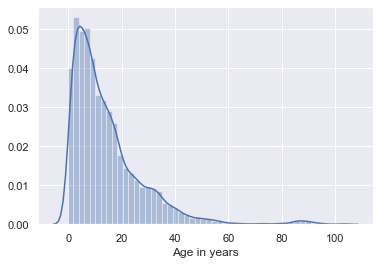

In [64]:
sns.distplot(mal_eda_df['Age in years']);

In [65]:
mal_df_tv = mal_eda_df[mal_eda_df['Type'] == 'TV']
mal_df_movie = mal_eda_df[mal_eda_df['Type'] == 'Movie']
mal_df_ova = mal_eda_df[mal_eda_df['Type'] == 'OVA']
mal_df_ona = mal_eda_df[mal_eda_df['Type'] == 'ONA']

#mal_test_df = mal_test_df[mal_test_df['Type'] == 'TV']

In [66]:
mal_eda_df['Total length'] = mal_df['Episodes'] * mal_df['Duration']
mal_test_df['Total length'] = mal_test_df['Episodes'] * mal_test_df['Duration']

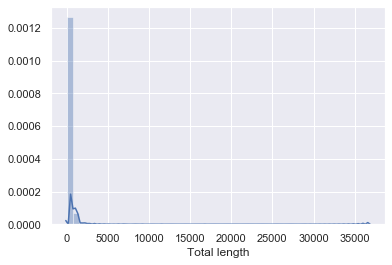

In [67]:
sns.distplot(mal_eda_df['Total length']);

In [68]:
mal_eda_df['Total length'].describe()

count     9164.000000
mean       232.067438
std        659.840589
min          0.000000
25%         23.000000
50%         60.000000
75%        276.000000
max      36775.000000
Name: Total length, dtype: float64

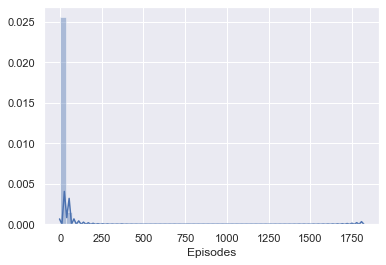

In [69]:
sns.distplot(mal_eda_df['Episodes']);

In [70]:
mal_eda_df['Episodes'].sort_values(ascending=False)

8935     1818.0
7809     1471.0
8337     1428.0
7685      726.0
4169      694.0
          ...  
16273       NaN
16362       NaN
16363       NaN
16374       NaN
16515       NaN
Name: Episodes, Length: 9257, dtype: float64

In [71]:
mal_eda_df[mal_eda_df['Episodes'] >= 200].Episodes.count()

25

In [72]:
mal_eda_df[mal_eda_df['Episodes'] < 200].Episodes.sort_values().tail(20)

561     145.0
3229    146.0
1290    147.0
3       148.0
5232    151.0
466     153.0
817     155.0
885     161.0
5333    164.0
727     167.0
6979    170.0
5098    170.0
5173    170.0
2268    172.0
743     175.0
1863    178.0
2901    180.0
4084    182.0
2752    191.0
3142    192.0
Name: Episodes, dtype: float64

In [73]:
mal_eda_df['Clipped episodes'] = mal_eda_df['Episodes'].clip(0,200)
mal_test_df['Clipped episodes'] = mal_test_df['Episodes'].clip(0,200)

In [74]:
mal_eda_df[mal_eda_df['Type'] == 'Movie']['Duration'].sort_values()

3061       0
10106      0
3461       0
5001       0
3420       0
        ... 
5041     150
3148     152
3069     153
235      156
3880     163
Name: Duration, Length: 1494, dtype: int64

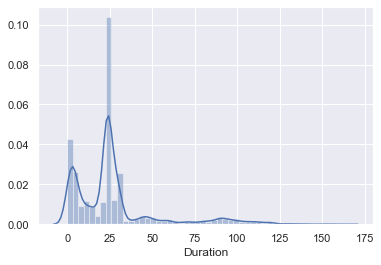

In [75]:
sns.distplot(mal_eda_df['Duration']);

In [76]:
mal_df_movie['Duration'].value_counts()

90     47
3      43
5      42
4      41
1      38
       ..
134     1
34      1
123     1
124     1
163     1
Name: Duration, Length: 143, dtype: int64

In [77]:
mal_eda_df[mal_eda_df['Finished?'] == False]

Title  \
30     Kaguya-sama wa Kokurasetai?: Tensai-tachi no R...   
109                                            One Piece   
307                            Toaru Kagaku no Railgun T   
315                                      Detective Conan   
596                                          Kami no Tou   
...                                                  ...   
16273                                              Inmou   
16362                                      Nozoki Kanojo   
16363               Sakuramiya Shimai no Netorare Kiroku   
16374                               Niplheim no Karyuudo   
16515                                    Valkyrie Hazard   

                                                     URL  \
30     https://myanimelist.net/anime/40591/Kaguya-sam...   
109           https://myanimelist.net/anime/21/One_Piece   
307    https://myanimelist.net/anime/38481/Toaru_Kaga...   
315    https://myanimelist.net/anime/235/Detective_Conan   
596      https://myanimelist.net/anime/40221/Kami_no_Tou   
...                                                  ...   
16273          https://myanimelist.net/anime/40922/Inmou   
16362  https://myanimelist.net/anime/40471/Nozoki_Kanojo   
16363  https://myanimelist.net/anime/39526/Sakuramiya...   
16374  https://myanimelist.net/anime/41212/Niplheim_n...   
16515  https://myanimelist.net/anime/40399/Valkyrie_H...   

                                 English  \
30     Kaguya-sama: Love is War Season 2   
109                            One Piece   
307       A Certain Scientific Railgun T   
315                          Case Closed   
596                         Tower of God   
...                                  ...   
16273                                NaN   
16362                                NaN   
16363                                NaN   
16374                                NaN   
16515                                NaN   

                                                Synonyms  \
30     Kaguya Wants to be Confessed To: The Geniuses'...   
109                                                   OP   
307    Toaru Kagaku no Railgun 3, Toaru Kagaku no Cho...   
315                                      Meitantei Conan   
596                                           Sin-ui Tap   
...                                                  ...   
16273                                                NaN   
16362                                                NaN   
16363                                                NaN   
16374                           The Huntress of Niplheim   
16515                                                NaN   

                      Japanese Type  Episodes            Status  \
30     かぐや様は告らせたい？～天才たちの恋愛頭脳戦～   TV      12.0  Currently Airing   
109                  ONE PIECE   TV       NaN  Currently Airing   
307         とある科学の超電磁砲[レールガン]T   TV      25.0  Currently Airing   
315                     名探偵コナン   TV       NaN  Currently Airing   
596         神之塔 -Tower of God-   TV      13.0  Currently Airing   
...                        ...  ...       ...               ...   
16273                       淫毛  OVA       NaN  Currently Airing   
16362                    のぞき彼女  OVA       NaN  Currently Airing   
16363              桜宮姉妹のネトラレ記録  OVA       NaN  Currently Airing   
16374                ニプルへイムの狩人  ONA       NaN  Currently Airing   
16515               ヴァルキリーハザード  OVA       NaN  Currently Airing   

                   Aired    Premiered  ... Side story Count Spin-off Count  \
30     Apr 11, 2020 to ?  Spring 2020  ...                0              0   
109    Oct 20, 1999 to ?    Fall 1999  ...               28              0   
307    Jan 10, 2020 to ?  Winter 2020  ...                0              0   
315     Jan 8, 1996 to ?  Winter 1996  ...               46              0   
596     Apr 2, 2020 to ?  Spring 2020  ...                0              0   
...                  ...          ...  ...              ...            ...   
16273  M

drop those currently airing

In [78]:
mal_eda_df = mal_eda_df[mal_eda_df['Finished?']]
mal_test_df = mal_test_df[mal_test_df['Finished?']]

Set movies with null episodes to 1

In [79]:
mal_eda_df.loc[(mal_eda_df['Type'] == 'Movie') & pd.isnull(mal_eda_df['Episodes']), 'Episodes'] = 1
mal_test_df.loc[(mal_test_df['Type'] == 'Movie') & pd.isnull(mal_test_df['Episodes']), 'Episodes'] = 1

In [80]:
mal_eda_df[pd.isnull(mal_eda_df['Episodes'])]

Empty DataFrame
Columns: [Title, URL, English, Synonyms, Japanese, Type, Episodes, Status, Aired, Premiered, Broadcast, Producers, Licensors, Studios, Source, Genres, Duration, Rating, Score, Ranked, Popularity, Members, Favorites, Started, Ended, Voters, Adaptation, Alternative version, Side story, Spin-off, Alternative setting, Sequel, Other, Prequel, Character, Parent story, Summary, Full story, Movie Type, Music Type, ONA Type, OVA Type, Special Type, TV Type, Action Genre, Adventure Genre, Comedy Genre, Drama Genre, Fantasy Genre, Hentai Genre, Music Genre, Sci-Fi Genre, Slice of Life Genre, Other Genre, Genre Count, Finished?, Rating score, Associated, Sequel Count, Alternative version Count, Adaptation Count, Other Count, Prequel Count, Parent story Count, Side story Count, Spin-off Count, Associated Count, No start date, UNIX started, Year started, Age timedelta, Age in years, Total length, Clipped episodes]
Index: []

[0 rows x 74 columns]

drop the remaining with null episodes if any (none in this case)

In [81]:
mal_eda_df = mal_eda_df[pd.isnull(mal_eda_df['Episodes']) == False]
mal_test_df = mal_test_df[pd.isnull(mal_test_df['Episodes']) == False]

In [82]:
mal_eda_df[mal_eda_df['Duration'] == 1][['Title', 'Type', 'Episodes', 'Aired', 'Duration']]

Title     Type  Episodes  \
1887                       Maria-sama ga Miteru Specials  Special       7.0   
2289              Higurashi no Naku Koro ni Kai Specials  Special      24.0   
2596                   Maria-sama ga Miteru 4th Specials  Special      11.0   
2711   Koukaku Kidoutai: Stand Alone Complex 2nd GIG ...  Special      26.0   
2876   Koukaku Kidoutai: Stand Alone Complex - Tachik...  Special      26.0   
...                                                  ...      ...       ...   
10216                                   Nendo no Tatakai      ONA       1.0   
10220                                            Shitcom      ONA       1.0   
15943  Shinkyoku no Grimoire The Animation: Unico no ...  Special       1.0   
16007                              Okane ga Nai Specials  Special       4.0   
16344                      Ikusa Otome Valkyrie Specials  Special       2.0   

                              Aired  Duration  
1887    Apr 4, 2004 to Oct 23, 2004         1  
2289   Sep 21, 2007 to Aug 22, 2008         1  
2596   Mar 25, 2009 to Aug 21, 2009         1  
2711   Sep 10, 2004 to Sep 27, 2006         1  
2876    Oct 1, 2002 to Mar 25, 2003         1  
...                             ...       ...  
10216                  Jan 28, 2004         1  
10220                  Sep 21, 2012         1  
15943                  Dec 25, 2015         1  
16007   Feb 9, 2007 to Dec 21, 2007         1  
16344  Dec 24, 2004 to Jan 28, 2005         1  

[287 rows x 5 columns]

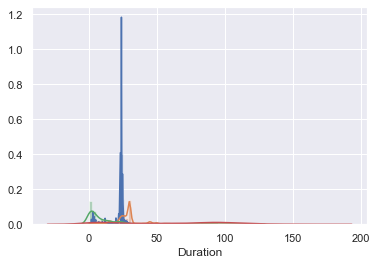

In [83]:
sns.distplot(mal_df_tv['Duration'], norm_hist=True)
sns.distplot(mal_df_ova['Duration'], norm_hist=True)
sns.distplot(mal_df_ona['Duration'], norm_hist=True)
sns.distplot(mal_df_movie['Duration'], norm_hist=True);

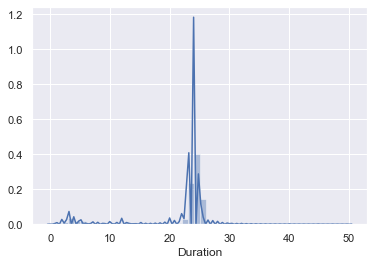

In [84]:
sns.distplot(mal_df_tv['Duration']);

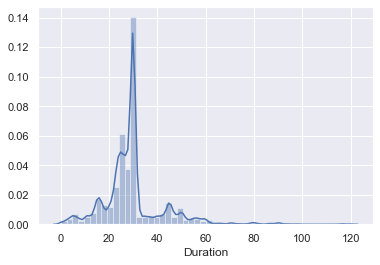

In [85]:
sns.distplot(mal_df_ova['Duration']);

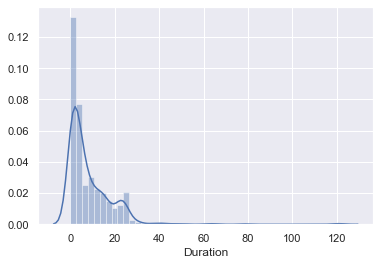

In [86]:
sns.distplot(mal_df_ona['Duration']);

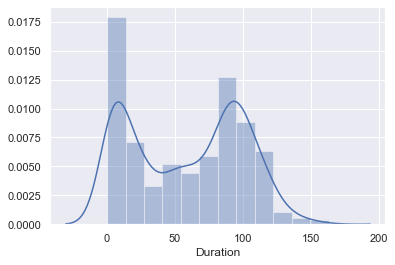

In [87]:
sns.distplot(mal_eda_df[mal_eda_df['Type'] == 'Movie']['Duration']);

In [88]:
mal_df_movie['Duration'].sort_values()

3061       0
10106      0
3461       0
5001       0
3420       0
        ... 
5041     150
3148     152
3069     153
235      156
3880     163
Name: Duration, Length: 1494, dtype: int64

In [89]:
mal_eda_df['Clipped duration'] = mal_eda_df['Duration'].clip(0,150)
mal_test_df['Clipped duration'] = mal_test_df['Duration'].clip(0,150)

In [90]:
mal_eda_df['Clipped length'] = mal_eda_df['Clipped duration'] * mal_eda_df['Clipped duration']
mal_test_df['Clipped length'] = mal_test_df['Clipped duration'] * mal_test_df['Clipped duration']

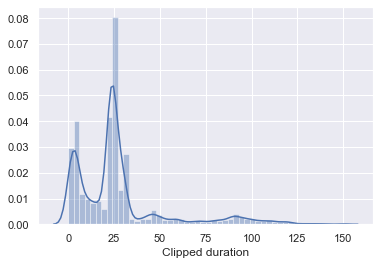

In [91]:
sns.distplot(mal_eda_df['Clipped duration']);

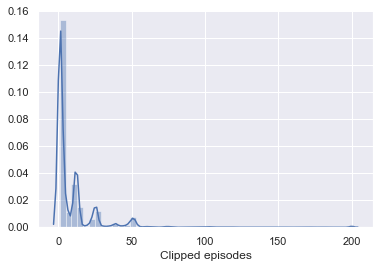

In [93]:
sns.distplot(mal_eda_df['Clipped episodes']);

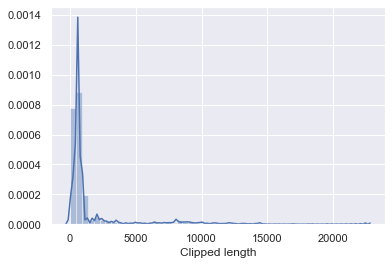

In [94]:
sns.distplot(mal_eda_df['Clipped length']);

In [95]:
mal_df_type_dummy.columns

Index(['Movie Type', 'Music Type', 'ONA Type', 'OVA Type', 'Special Type',
       'TV Type'],
      dtype='object')

In [96]:
mal_eda_df.columns

Index(['Title', 'URL', 'English', 'Synonyms', 'Japanese', 'Type', 'Episodes',
       'Status', 'Aired', 'Premiered', 'Broadcast', 'Producers', 'Licensors',
       'Studios', 'Source', 'Genres', 'Duration', 'Rating', 'Score', 'Ranked',
       'Popularity', 'Members', 'Favorites', 'Started', 'Ended', 'Voters',
       'Adaptation', 'Alternative version', 'Side story', 'Spin-off',
       'Alternative setting', 'Sequel', 'Other', 'Prequel', 'Character',
       'Parent story', 'Summary', 'Full story', 'Movie Type', 'Music Type',
       'ONA Type', 'OVA Type', 'Special Type', 'TV Type', 'Action Genre',
       'Adventure Genre', 'Comedy Genre', 'Drama Genre', 'Fantasy Genre',
       'Hentai Genre', 'Music Genre', 'Sci-Fi Genre', 'Slice of Life Genre',
       'Other Genre', 'Genre Count', 'Finished?', 'Rating score', 'Associated',
       'Sequel Count', 'Alternative version Count', 'Adaptation Count',
       'Other Count', 'Prequel Count', 'Parent story Count',
       'Side story Count', 'Spin-

In [97]:
mal_type_cols = mal_df_type_dummy.columns.to_list()

mal_type_cols_less1 = [mal_type for mal_type in mal_type_cols if mal_type not in ['TV Genre', 'Unknown Genre']]

mal_features = ['Age in years', 'Year started', 'Clipped duration', 'Clipped episodes', 'Clipped length', 'Genre Count', 'Rating score', 'Members', 'Favorites', 'Voters'] + mal_type_cols + mal_associated_counts_col + genre_dummy.columns.tolist() # R^2 = 0.55
mal_features_target = ['Score'] + mal_features

print(mal_features)
print(len(mal_features))

mal_train_df = mal_eda_df[mal_features_target].dropna()
X = mal_train_df.loc[:,mal_features]
y = mal_train_df['Score']

['Age in years', 'Year started', 'Clipped duration', 'Clipped episodes', 'Clipped length', 'Genre Count', 'Rating score', 'Members', 'Favorites', 'Voters', 'Movie Type', 'Music Type', 'ONA Type', 'OVA Type', 'Special Type', 'TV Type', 'Sequel Count', 'Alternative version Count', 'Adaptation Count', 'Other Count', 'Prequel Count', 'Parent story Count', 'Side story Count', 'Spin-off Count', 'Associated Count', 'Action Genre', 'Adventure Genre', 'Comedy Genre', 'Drama Genre', 'Fantasy Genre', 'Hentai Genre', 'Music Genre', 'Sci-Fi Genre', 'Slice of Life Genre', 'Other Genre']
35


In [98]:
mal_train_df

Score  Age in years  Year started  Clipped duration  Clipped episodes  \
0       9.23     11.076712          2009                24              64.0   
2       9.12      5.065753          2015                24              51.0   
3       9.12      8.583562          2011                23             148.0   
4       9.11     32.331507          1988                26             110.0   
5       9.10      9.079452          2011                24              51.0   
...      ...           ...           ...               ...               ...   
16656   4.74     18.369863          2001                19               1.0   
16657   4.70     13.654795          2006                34               1.0   
16660   4.58     18.772603          2001                22               1.0   
16661   4.57     18.386301          2001                21               1.0   
16662   4.47     25.501370          1994                74               1.0   

       Clipped length  Genre Count  Rating score  Members  Favorites  ...  \
0                 576            8             3  1739484     148909  ...   
2                 576            7             2   305233       8270  ...   
3                 529            5             2  1159669     104155  ...   
4                 676            4             3   186530      11731  ...   
5                 576            7             2   295318       5409  ...   
...               ...          ...           ...      ...        ...  ...   
16656             361            1             5     1089          2  ...   
16657            1156            2             5   105145       1577  ...   
16660             484            1             5     1080          3  ...   
16661             441            1             5     1285          6  ...   
16662            5476            2             5      753          0  ...   

       Action Genre  Adventure Genre  Comedy Genre  Drama Genre  \
0                 1                0             0            0   
2                 1                0             0            0   
3                 1                0             0            0   
4                 0                0             0            0   
5                 1                0             0            0   
...             ...              ...           ...          ...   
16656             0                0             0            0   
16657             0                0             0            0   
16660             0                0             0            0   
16661             0                0             0            0   
16662             1                0             0            0   

       Fantasy Genre  Hentai Genre  Music Genre  Sci-Fi Genre  \
0                  0             0            0             0   
2                  0             0            0             0   
3                  0             0            0             0   
4                  0             0            0             0   
5                  0             0            0             0   
...              ...           ...          ...           ...   
16656              0             1            0             0   
16657              0             1            0             0   
16660              0             1            0             0   
16661              0             1            0             0   
16662              0             0            0             0   

       Slice of Life Genre  Other Genre  
0                        0            0  
2                        0            0  
3                        0            0  
4                        0            1  
5                        0            0  
...                    ...          ...  
16656                    0            0  
16657                    0            0  
16660                    0            0  
16661                    0            0  
16662                    0            0  

[9141 rows x 36 columns]

In [99]:
def LinearRegressionCV(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    num_features = X.columns.size
    num_rows = len(X.index)

    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    val_adj_score = 1 - (1 - val_score) * (num_rows - 1) / (num_rows - num_features - 1)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Validation adjusted R^2 score was:', val_adj_score)
    print('\nFeature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

    return lr_model

In [133]:
lr_model_default = LinearRegressionCV(X, y)

model_scores(X, y, lr_model_default)


Validation R^2 score was: 0.5368348665572777
Validation adjusted R^2 score was: 0.5350544404539833

Feature coefficient results: 

Age in years : -0.09
Year started : -0.07
Clipped duration : 0.02
Clipped episodes : 0.01
Clipped length : -0.00
Genre Count : 0.08
Rating score : -0.04
Members : 0.00
Favorites : -0.00
Voters : -0.00
Movie Type : -0.06
Music Type : -0.03
ONA Type : -0.10
OVA Type : -0.08
Special Type : 0.16
TV Type : 0.11
Sequel Count : 0.28
Alternative version Count : 0.23
Adaptation Count : 0.30
Other Count : 0.20
Prequel Count : 0.40
Parent story Count : 0.51
Side story Count : 0.15
Spin-off Count : 0.18
Associated Count : -0.17
Action Genre : 2.55
Adventure Genre : 2.75
Comedy Genre : 2.71
Drama Genre : 2.89
Fantasy Genre : 2.61
Hentai Genre : 2.82
Music Genre : 2.72
Sci-Fi Genre : 2.53
Slice of Life Genre : 2.73
Other Genre : 2.56
Mean Sq Err:   0.37599888246455215
Mean Abs Err:  0.47843113581463015
Max Err:       3.980856009672641
R^2:           0.5063188955502009


In [101]:
def transform_col(df, col_list, func_list):
    '''
    transforms columns in col_list in a df with a list of functions in the order specified in func_list
    the old columns are dropped and new columns added with name being old_col name prefixed by func_list
    '''
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df is not DataFrame")
    if set(df.columns.tolist()).isdisjoint(set(col_list)):
        raise TypeError("old_col not a column in df")
    if isinstance(func_list, list):
        if not all(callable(func) for func in func_list):
            raise TypeError("not all functions in list are callable")
    if callable(func_list):
        func_list = [func_list]
    else:
        raise TypeError("func_list must be function or list of functions")

    for old_col in col_list:
        new_col_df = df[old_col]
        new_col_name = old_col
        for func in func_list:
            new_col_df = func(new_col_df)
            new_col_name = func.__name__ + " " + new_col_name
    
        df[new_col_name] = new_col_df
        df.drop(old_col, axis=1, inplace=True)


In [102]:
def logplus(n):
    return np.log10(n+1)

In [103]:
mal_logtransform_list = ['Clipped episodes', 'Clipped duration', 'Clipped length', 'Associated Count', 'Genre Count', 'Members', 'Favorites', 'Year started', 'Age in years']

mal_tt_df = pd.DataFrame()
mal_tt_df = pd.DataFrame(mal_eda_df)
transform_col(mal_tt_df, mal_logtransform_list, logplus)

print(mal_tt_df.columns)

Index(['Title', 'URL', 'English', 'Synonyms', 'Japanese', 'Type', 'Episodes',
       'Status', 'Aired', 'Premiered', 'Broadcast', 'Producers', 'Licensors',
       'Studios', 'Source', 'Genres', 'Duration', 'Rating', 'Score', 'Ranked',
       'Popularity', 'Started', 'Ended', 'Voters', 'Adaptation',
       'Alternative version', 'Side story', 'Spin-off', 'Alternative setting',
       'Sequel', 'Other', 'Prequel', 'Character', 'Parent story', 'Summary',
       'Full story', 'Movie Type', 'Music Type', 'ONA Type', 'OVA Type',
       'Special Type', 'TV Type', 'Action Genre', 'Adventure Genre',
       'Comedy Genre', 'Drama Genre', 'Fantasy Genre', 'Hentai Genre',
       'Music Genre', 'Sci-Fi Genre', 'Slice of Life Genre', 'Other Genre',
       'Finished?', 'Rating score', 'Associated', 'Sequel Count',
       'Alternative version Count', 'Adaptation Count', 'Other Count',
       'Prequel Count', 'Parent story Count', 'Side story Count',
       'Spin-off Count', 'No start date', 'UNIX star

In [104]:
mal_train_df['Log episodes'] = np.log10(mal_train_df['Clipped episodes'] + 1)
mal_train_df['Log duration'] = np.log10(mal_train_df['Clipped duration'] + 1)
mal_train_df['Log length'] = np.log10(mal_train_df['Clipped length'] + 1)
mal_train_df['Log assoc count'] = np.log10(mal_train_df['Associated Count'] + 1)
mal_train_df['Log genre count'] = np.log10(mal_train_df['Genre Count'] + 1)
mal_train_df['Log members'] = np.log10(mal_train_df['Members'] + 1)
mal_train_df['Log log members'] = np.log10(mal_train_df['Log members'] + 1)
mal_train_df['Log favorites'] = np.log10(mal_train_df['Favorites'] + 1)
mal_train_df['Log fav over log members'] = mal_train_df['Log favorites'] / mal_train_df['Log members']
#mal_train_df['Log UNIX started'] = np.log10(mal_train_df['UNIX started'])
mal_train_df['Sqrt year started'] = np.sqrt(mal_train_df['Year started'])
mal_train_df['Log age'] = np.log10(mal_train_df['Age in years'] + 1)

mal_test_df['Log episodes'] = np.log10(mal_test_df['Clipped episodes'] + 1)
mal_test_df['Log duration'] = np.log10(mal_test_df['Clipped duration'] + 1)
mal_test_df['Log length'] = np.log10(mal_test_df['Clipped length'] + 1)
mal_test_df['Log assoc count'] = np.log10(mal_test_df['Associated Count'] + 1)
mal_test_df['Log genre count'] = np.log10(mal_test_df['Genre Count'] + 1)
mal_test_df['Log members'] = np.log10(mal_test_df['Members'] + 1)
mal_test_df['Log log members'] = np.log10(mal_test_df['Log members'] + 1)
mal_test_df['Log favorites'] = np.log10(mal_test_df['Favorites'] + 1)
mal_test_df['Log fav over log members'] = mal_test_df['Log favorites'] / mal_test_df['Log members']
#mal_test_df['Log UNIX started'] = np.log10(mal_test_df['UNIX started'])
mal_test_df['Sqrt year started'] = np.sqrt(mal_test_df['Year started'])
mal_test_df['Log age'] = np.log10(mal_test_df['Age in years'] + 1)

In [105]:
mal_typelen_cols = [anime_type + " length" for anime_type in mal_type_cols]
mal_typeloglen_cols = [anime_type + " log length" for anime_type in mal_type_cols]

for anime_type in mal_type_cols:
    mal_train_df[anime_type + " length"] = mal_train_df[anime_type] * mal_train_df['Clipped length']
    mal_train_df[anime_type + " log length"] = mal_train_df[anime_type] * mal_train_df['Log length']

    mal_test_df[anime_type + " length"] = mal_test_df[anime_type] * mal_test_df['Clipped length']
    mal_test_df[anime_type + " log length"] = mal_test_df[anime_type] * mal_test_df['Log length']

mal_train_df['TV Type length']

0        576
2        576
3        529
4          0
5        576
        ... 
16656      0
16657      0
16660      0
16661      0
16662      0
Name: TV Type length, Length: 9141, dtype: int64

In [106]:
mal_associated_logcounts_col = ['Log ' + assoc_count + ' Count' for assoc_count in mal_associated_cols]

for assoc_count in mal_associated_cols:
    mal_train_df['Log ' + assoc_count + ' Count'] = np.log10(mal_train_df[assoc_count + ' Count'] + 1)
    mal_test_df['Log ' + assoc_count + ' Count'] = np.log10(mal_test_df[assoc_count + ' Count'] + 1)

mal_train_df['Log Sequel Count']

0        0.00000
2        0.30103
3        0.00000
4        0.00000
5        0.30103
          ...   
16656    0.00000
16657    0.30103
16660    0.00000
16661    0.00000
16662    0.00000
Name: Log Sequel Count, Length: 9141, dtype: float64

In [134]:
mal_genre_loglength_list = ['Log ' + genre + ' length' for genre in genre_dummy.columns.tolist()]

for genre in genre_dummy.columns.tolist():
    mal_train_df['Log ' + genre + ' length'] =  mal_train_df[genre] * mal_train_df['Log length']
    mal_test_df['Log ' + genre + ' length'] =  mal_test_df[genre] * mal_test_df['Log length']

mal_train_df['Action Genre']

0        1
2        1
3        1
4        0
5        1
        ..
16656    0
16657    0
16660    0
16661    0
16662    1
Name: Action Genre, Length: 9141, dtype: uint8

In [108]:
mal_train_df.describe()

Score  Age in years  Year started  Clipped duration  \
count  9141.000000   9141.000000   9141.000000       9141.000000   
mean      6.574238     14.571967   2005.301389         27.064216   
std       0.872758     13.677058     13.639259         25.745164   
min       1.900000     -0.169863   1917.000000          0.000000   
25%       6.010000      5.246575   2001.000000          9.000000   
50%       6.580000     10.676712   2009.000000         24.000000   
75%       7.190000     19.153425   2015.000000         30.000000   
max       9.230000    103.150685   2020.000000        150.000000   

       Clipped episodes  Clipped length  Genre Count  Rating score  \
count       9141.000000     9141.000000  9141.000000   9141.000000   
mean          10.302812     1395.212778     3.225249      2.081720   
std           19.797956     2828.517018     1.998391      1.495798   
min            1.000000        0.000000     1.000000      0.000000   
25%            1.000000       81.000000     2.000000      1.000000   
50%            2.000000      576.000000     3.000000      2.000000   
75%           12.000000      900.000000     4.000000      3.000000   
max          200.000000    22500.000000    30.000000      5.000000   

            Members      Favorites  ...  Log Action Genre length  \
count  9.141000e+03    9141.000000  ...              9141.000000   
mean   4.099503e+04     541.035663  ...                 0.758550   
std    1.170725e+05    3811.881307  ...                 1.316787   
min    1.800000e+02       0.000000  ...                 0.000000   
25%    1.508000e+03       2.000000  ...                 0.000000   
50%    5.044000e+03       9.000000  ...                 0.000000   
75%    2.489400e+04      64.000000  ...                 1.414973   
max    2.001237e+06  148909.000000  ...                 4.352202   

       Log Adventure Genre length  Log Comedy Genre length  \
count                 9141.000000              9141.000000   
mean                     0.250975                 0.374266   
std                      0.842360                 0.904342   
min                      0.000000                 0.000000   
25%                      0.000000                 0.000000   
50%                      0.000000                 0.000000   
75%                      0.000000                 0.000000   
max                      4.298460                 4.158393   

       Log Drama Genre length  Log Fantasy Genre length  \
count             9141.000000               9141.000000   
mean                 0.118198                  0.069014   
std                  0.588942                  0.440751   
min                  0.000000                  0.000000   
25%                  0.000000                  0.000000   
50%                  0.000000                  0.000000   
75%                  0.000000                  0.000000   
max                  4.352202                  4.273464   

       Log Hentai Genre length  Log Music Genre length  \
count              9141.000000              9141.00000   
mean                  0.257295                 0.08564   
std                   0.816717                 0.39211   
min                   0.000000                 0.00000   
25%                   0.000000                 0.00000   
50%                   0.000000                 0.00000   
75%                   0.000000                 0.00000   
max                   4.227912                 4.16560   

       Log Sci-Fi Genre length  Log Slice of Life Genre length  \
count              9141.000000                     9141.000000   
mean                  0.084837                        0.105872   
std                   0.490747                        0.512416   
min                   0.000000                        0.000000   
25%                   0.000000                        0.000000   
50%                   0.000000                        0.000000   
75%                   0.000000                        0.000000   
max           

In [109]:
 mal_genre_loglength_list

['Log Action Genre length',
 'Log Adventure Genre length',
 'Log Comedy Genre length',
 'Log Drama Genre length',
 'Log Fantasy Genre length',
 'Log Hentai Genre length',
 'Log Music Genre length',
 'Log Sci-Fi Genre length',
 'Log Slice of Life Genre length',
 'Log Other Genre length']

In [110]:
# R^2 = 0.70
mal_features_trans = mal_train_df.columns.tolist()
mal_features_trans.remove('Score')

In [111]:
print(mal_features_trans)
print(len(mal_features_trans))

['Age in years', 'Year started', 'Clipped duration', 'Clipped episodes', 'Clipped length', 'Genre Count', 'Rating score', 'Members', 'Favorites', 'Voters', 'Movie Type', 'Music Type', 'ONA Type', 'OVA Type', 'Special Type', 'TV Type', 'Sequel Count', 'Alternative version Count', 'Adaptation Count', 'Other Count', 'Prequel Count', 'Parent story Count', 'Side story Count', 'Spin-off Count', 'Associated Count', 'Action Genre', 'Adventure Genre', 'Comedy Genre', 'Drama Genre', 'Fantasy Genre', 'Hentai Genre', 'Music Genre', 'Sci-Fi Genre', 'Slice of Life Genre', 'Other Genre', 'Log episodes', 'Log duration', 'Log length', 'Log assoc count', 'Log genre count', 'Log members', 'Log log members', 'Log favorites', 'Log fav over log members', 'Sqrt year started', 'Log age', 'Movie Type length', 'Movie Type log length', 'Music Type length', 'Music Type log length', 'ONA Type length', 'ONA Type log length', 'OVA Type length', 'OVA Type log length', 'Special Type length', 'Special Type log length',

In [112]:
def anscombe(x):
    '''
    Compute the anscombe variance stabilizing transform.
      the input   x   is noisy Poisson-distributed data
      the output  fx  has variance approximately equal to 1.
    Reference: Anscombe, F. J. (1948), "The transformation of Poisson,
    binomial and negative-binomial data", Biometrika 35 (3-4): 246-254
    '''
    return 2.0*np.sqrt(x + 3.0/8.0)

def inverse_anscombe(z):
    '''
    Compute the inverse transform using an approximation of the exact
    unbiased inverse.
    Reference: Makitalo, M., & Foi, A. (2011). A closed-form
    approximation of the exact unbiased inverse of the Anscombe
    variance-stabilizing transformation. Image Processing.
    '''
    #return (z/2.0)**2 - 3.0/8.0
    return (1.0/4.0 * np.power(z, 2) +
            1.0/4.0 * np.sqrt(3.0/2.0) * np.power(z, -1.0) -
            11.0/8.0 * np.power(z, -2.0) + 
            5.0/8.0 * np.sqrt(3.0/2.0) * np.power(z, -3.0) - 1.0 / 8.0)

def generalized_anscombe(x, mu, sigma, gain=1.0):
    '''
    Compute the generalized anscombe variance stabilizing transform,
    which assumes that the data provided to it is a mixture of poisson
    and gaussian noise.
    The input signal  z  is assumed to follow the Poisson-Gaussian noise model
        x = gain * p + n
    where gain is the camera gain and mu and sigma are the read noise
    mean and standard deviation.
    We assume that x contains only positive values.  Values that are
    less than or equal to 0 are ignored by the transform.
    Note, this transform will show some bias for counts less than
    about 20.
    '''
    y = gain*x + (gain**2)*3.0/8.0 + sigma**2 - gain*mu

    # Clamp to zero before taking the square root.
    return (2.0/gain)*np.sqrt(np.maximum(y, 0.0))

def inverse_generalized_anscombe(x, mu, sigma, gain=1.0):
    '''
    Applies the closed-form approximation of the exact unbiased
    inverse of Generalized Anscombe variance-stabilizing
    transformation.
    The input signal x is transform back into a Poisson random variable
    based on the assumption that the original signal from which it was
    derived follows the Poisson-Gaussian noise model:
        x = gain * p + n
    where gain is the camera gain and mu and sigma are the read noise
    mean and standard deviation.
    Roference: M. Makitalo and A. Foi, "Optimal inversion of the
    generalized Anscombe transformation for Poisson-Gaussian noise",
    IEEE Trans. Image Process., doi:10.1109/TIP.2012.2202675
    '''
    test = np.maximum(x, 1.0)
    exact_inverse = ( np.power(test/2.0, 2.0) +
                      1.0/4.0 * np.sqrt(3.0/2.0)*np.power(test, -1.0) -
                      11.0/8.0 * np.power(test, -2.0) +
                      5.0/8.0 * np.sqrt(3.0/2.0) * np.power(test, -3.0) -
                      1.0/8.0 - np.power(sigma, 2) )
    exact_inverse = np.maximum(0.0, exact_inverse)
    exact_inverse *= gain
    exact_inverse += mu
    exact_inverse[np.where(exact_inverse != exact_inverse)] = 0.0
    return exact_inverse

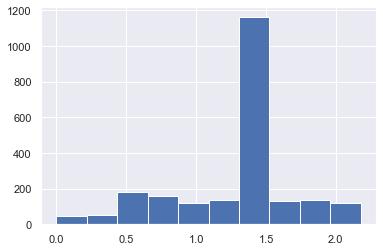

In [113]:
mal_test_df['Log duration'].hist();
#sns.distplot(np.log(mal_test_df['Genre Count']));

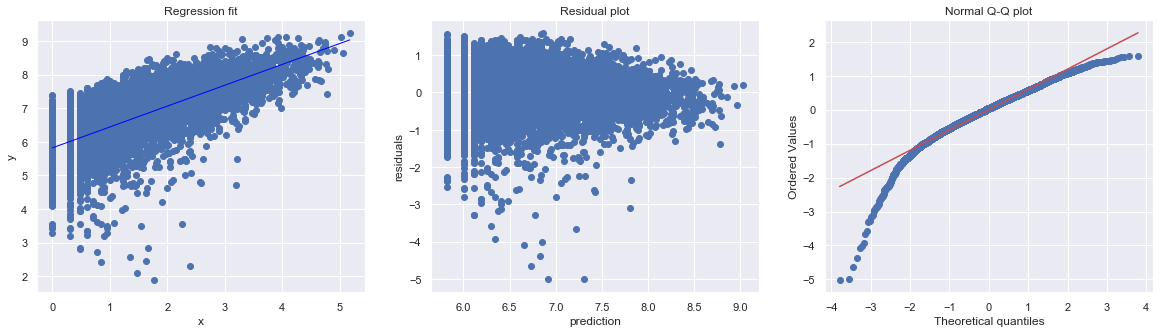

In [114]:
eda.diagnostic_plot(mal_train_df.loc[:,['Log favorites']], mal_train_df['Score'])

Manual selection of parameters based on below tests

In [148]:
mal_features_sig = ['Log genre count', 'Prequel Count', 'Parent story Count', 'Log assoc count', 'Log length', 'Log log members', 'Special Type']
#mal_features_sig = ['Log genre count', 'Prequel Count', 'Parent story Count', 'Log assoc count', 'Log length', 'Log log members', 'Special Type', 'Adventure Genre', 'Comedy Genre', 'Drama Genre', 'Slice of Life Genre']
#mal_features_sig = ['Log genre count', 'Prequel Count', 'Parent story Count', 'Log assoc count', 'Log length', 'Log log members', 'Special Type', 'Log Adventure Genre length', 'Log Comedy Genre length', 'Log Drama Genre length', 'Log Slice of Life Genre length']
#mal_features_sig = ['Age in years', 'Year started', 'Clipped duration', 'Clipped episodes', 'Clipped length', 'Genre Count', 'Rating score', 'Members', 'Favorites', 'Voters', 'Movie Type', 'Music Type', 'ONA Type', 'OVA Type', 'Special Type', 'TV Type', 'Sequel Count', 'Alternative version Count', 'Adaptation Count', 'Other Count', 'Prequel Count', 'Parent story Count', 'Side story Count', 'Spin-off Count', 'Associated Count', 'Action Genre', 'Adventure Genre', 'Comedy Genre', 'Drama Genre', 'Fantasy Genre', 'Hentai Genre', 'Music Genre', 'Sci-Fi Genre', 'Slice of Life Genre', 'Other Genre', 'Log episodes', 'Log duration', 'Log length', 'Log assoc count', 'Log genre count', 'Log members', 'Log log members', 'Log favorites', 'Log fav over log members', 'Sqrt year started', 'Log age', 'Movie Type length', 'Movie Type log length', 'Music Type length', 'Music Type log length', 'ONA Type length', 'ONA Type log length', 'OVA Type length', 'OVA Type log length', 'Special Type length', 'Special Type log length', 'TV Type length', 'TV Type log length', 'Log Sequel Count', 'Log Alternative version Count', 'Log Adaptation Count', 'Log Other Count', 'Log Prequel Count', 'Log Parent story Count', 'Log Side story Count', 'Log Spin-off Count', 'Log Action Genre length', 'Log Adventure Genre length', 'Log Comedy Genre length', 'Log Drama Genre length', 'Log Fantasy Genre length', 'Log Hentai Genre length', 'Log Music Genre length', 'Log Sci-Fi Genre length', 'Log Slice of Life Genre length', 'Log Other Genre length']
mal_features_sig_score = ['Score'] + mal_features_sig 
len(mal_features_sig)

7

In [116]:
#sns.pairplot(mal_test_df[mal_features_sig_score], plot_kws=dict(alpha=.1, edgecolor='none'));

Stats test

In [149]:
X = mal_train_df.loc[:,mal_features_sig]
y = mal_train_df['Score']

lr_model_stats = sm.OLS(y, sm.add_constant(X)).fit()
lr_model_stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     1710.
Date:                Thu, 30 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:36:08   Log-Likelihood:                -7898.3
No. Observations:                9141   AIC:                         1.581e+04
Df Residuals:                    9133   BIC:                         1.587e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.3953      0.059     23.811      0.000       1.280       1.510
Log genre count        0.2574      0.037      6.934      0.000       0.185       0.330
Prequel Count          0.1628      0.015     10.858      0.000       0.133       0.192
Parent story Count     0.1750      0.018      9.926      0.000       0.140       0.210
Log assoc count        0.4174      0.031     13.486      0.000       0.357       0.478
Log length             0.1725      0.007     24.719      0.000       0.159       0.186
Log log members        6.4997      0.100     65.032      0.000       6.304       6.696
Special Type           0.1116      0.019      5.972      0.000       0.075       0.148
==============================================================================
Omnibus:                     1654.687   Durbin-Watson:                   1.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5646.923
Skew:                          -0.902   Prob(JB):                         0.00
Kurtosis:                       6.402   Cond. No.                         56.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Use LASSO to limit further

In [150]:
lasso_model = Lasso(alpha=.01)
lasso_model.fit(X, y)

for label, value in zip(X.columns, lasso_model.coef_):
    if value > 0.01:
        print(label, ":", value)

print(lasso_model.score(X, y))

Log genre count : 0.24816495534265468
Prequel Count : 0.12685802858235604
Parent story Count : 0.12640504797676172
Log assoc count : 0.5519192789644696
Log length : 0.2084321335332469
Log log members : 4.364828082841643
Special Type : 0.05525924735763571
0.5394368561518388


In [119]:
def model_scores(X, y, model):

    actual = y
    predicted = model.predict(X)
    
    print("Mean Sq Err:  ", mean_squared_error(actual, predicted))
    print("Mean Abs Err: ", mean_absolute_error(actual, predicted))
    print("Max Err:      ", max_error(actual, predicted))
    print("R^2:          ", r2_score(actual, predicted))

In [151]:
lr_model_mod = LinearRegressionCV(X, y)

model_scores(X, y, lr_model_mod)


Validation R^2 score was: 0.6037691190433279
Validation adjusted R^2 score was: 0.6034654273574966

Feature coefficient results: 

Log genre count : 0.29
Prequel Count : 0.17
Parent story Count : 0.18
Log assoc count : 0.40
Log length : 0.18
Log log members : 6.42
Special Type : 0.11
Mean Sq Err:   0.32971697061450356
Mean Abs Err:  0.43236470099296254
Max Err:       4.738403062383483
R^2:           0.5670863776459337


In [152]:
ridge_model = RidgeCV()
ridge_model.fit(X, y)

print(ridge_model.coef_)
model_scores(X, y, ridge_model)

[0.2594139  0.162644   0.17491982 0.41948913 0.172783   6.48032186
 0.11172127]
Mean Sq Err:   0.329632186836994
Mean Abs Err:  0.43210137398752857
Max Err:       4.7376972718348895
R^2:           0.567197697521796


In [153]:
lasso_model = LassoCV(alphas=np.arange(0.001, 1, 0.001), random_state=42)
lasso_model.fit(X, y)

print(lasso_model.coef_)
print(lasso_model.alpha_)
model_scores(X, y, lasso_model)

[0.25654343 0.15917732 0.17017041 0.43075152 0.17606779 6.28635721
 0.10593318]
0.001
Mean Sq Err:   0.32984214007345586
Mean Abs Err:  0.4323138607119573
Max Err:       4.728393862820594
R^2:           0.5669220319533776


In [156]:
final_model = lr_model_mod

mal_testfinal_df = mal_test_df[mal_features_sig_score].dropna()
test_X = mal_testfinal_df.loc[:,mal_features_sig]
test_y = mal_testfinal_df['Score']

model_scores(test_X, test_y, final_model)

Mean Sq Err:   0.30975186898565527
Mean Abs Err:  0.42762458069871345
Max Err:       3.0326491304013046
R^2:           0.5812375545659142
